In [63]:
import meep as mp
import matplotlib.pyplot as plt
import nlopt
import numpy as np
import pickle
from meep_material import lorentzfit
import os

In [64]:
resolution = 100
nfreq = 300
fcen = 1.75
df = 3.3

In [65]:
import numpy as np
import meep as mp
import nlopt
from typing import Tuple

# lorentzfit 함수는 이미 정의되어 있어야 함 (여기선 너가 가지고 있다고 가정함)

def fit_material_from_csv(
    csv_path: str,
    wl_range_nm = [0.38, 0.72],
    eps_inf: float = 1.1,
    num_lorentzians: int = 3,
    num_repeat: int = 100,
    opt_tol: float = 1e-25,
    maxeval: int = 50000,
) -> mp.Medium:
    # --- 0) 피클 경로 설정 ---
    base, _ = os.path.splitext(csv_path)
    pickle_path = base + "_fit.pkl"

    # --- 1) 피클이 있으면 로드 후 반환 ---
    if os.path.exists(pickle_path):
        with open(pickle_path, "rb") as f:
            eps_inf, E_sus, freq_range = pickle.load(f)
        print(f"Loaded fit from pickle: {pickle_path}")
        return eps_inf, E_sus, freq_range
    
    # 데이터 불러오기
    mydata = np.genfromtxt(csv_path, delimiter=",")
    wl = mydata[:, 0]  # um
    n_complex = mydata[:, 1] + 1j * mydata[:, 2]
    eps_data = np.square(n_complex) - eps_inf  # 유전율에서 eps_inf 보정

    # 파장 범위 필터링
    wl_min, wl_max = wl_range_nm
    idx_start = np.where(wl > wl_min)[0][0]
    idx_end = np.where(wl < wl_max)[0][-1] + 1
    wl_reduced = wl[idx_start:idx_end]
    eps_reduced = eps_data[idx_start:idx_end]
    freqs_reduced = 1 / wl_reduced  # nm → 1/μm (Meep 단위)

    # 최적화 반복
    ps = np.zeros((num_repeat, 3 * num_lorentzians))
    mins = np.zeros(num_repeat)

    for m in range(num_repeat):
        p_rand = [10 ** (np.random.random()) for _ in range(3 * num_lorentzians)]
        ps[m, :], mins[m] = lorentzfit(
            p_rand, freqs_reduced, eps_reduced, nlopt.LD_MMA, opt_tol, maxeval
        )
        print(f"[{m:2d}] RMS error: {mins[m]:.6e} — params: {ps[m, :]}")

    # 최적 피팅 결과 선택
    idx_opt = np.argmin(mins)
    popt = ps[idx_opt, :]
    print(f"\n>> Best fit RMS error = {mins[idx_opt]:.6e}")
    print(f">> Optimal parameters = {popt}")

    # mp.Medium 구성
    E_sus = []

    for i in range(num_lorentzians):
        sigma = popt[3 * i + 0]
        freq = popt[3 * i + 1]
        gamma = popt[3 * i + 2]

        if freq == 0:
            # Drude 항
            E_sus.append(mp.DrudeSusceptibility(frequency=1.0, gamma=gamma, sigma=sigma))
        else:
            # Lorentz 항
            sigma_adj = sigma / freq**2
            E_sus.append(mp.LorentzianSusceptibility(frequency=freq, gamma=gamma, sigma=sigma_adj))

    # 유효 주파수 범위 설정
    freq_min = 1 / wl_max
    freq_max = 1 / wl_min
    freq_range = mp.FreqRange(min=freq_min, max=freq_max)

    # --- 6) 결과를 피클로 저장 ---
    with open(pickle_path, "wb") as f:
        pickle.dump((eps_inf, E_sus, freq_range), f)

    return eps_inf, E_sus, freq_range

sio2_data_path = "/home/min/EIDL/Tool/Meep/LGD/Meep code/OLED structure/Layer by Layer check/New fitting/Refractive Index data/Sio2/Material_merged.csv"
al_data_path   = "/home/min/EIDL/Tool/Meep/LGD/Meep code/OLED structure/Layer by Layer check/New fitting/Refractive Index data/Al/mat/Material_merged.csv"
andp_data_path = "/home/min/EIDL/Tool/Meep/LGD/Meep code/OLED structure/Layer by Layer check/New fitting/Refractive Index data/aNDP/Material_merged.csv"

In [66]:
eps_inf_sio2, suscept_sio2, freq_sio2 = fit_material_from_csv(csv_path=sio2_data_path, num_lorentzians=2,  wl_range_nm = [0.38, 0.72])
eps_inf_al, suscept_al, freq_al = fit_material_from_csv(csv_path=al_data_path, num_lorentzians=7)
eps_inf_andp, suscept_andp, freq_andp = fit_material_from_csv(csv_path=andp_data_path, num_lorentzians=5,  wl_range_nm = [0.4, 0.7])

Loaded fit from pickle: /home/min/EIDL/Tool/Meep/LGD/Meep code/OLED structure/Layer by Layer check/New fitting/Refractive Index data/Sio2/Material_merged_fit.pkl
Loaded fit from pickle: /home/min/EIDL/Tool/Meep/LGD/Meep code/OLED structure/Layer by Layer check/New fitting/Refractive Index data/Al/mat/Material_merged_fit.pkl
Loaded fit from pickle: /home/min/EIDL/Tool/Meep/LGD/Meep code/OLED structure/Layer by Layer check/New fitting/Refractive Index data/aNDP/Material_merged_fit.pkl


In [67]:
sio2 =  mp.Medium(epsilon = eps_inf_sio2,   E_susceptibilities = suscept_sio2, valid_freq_range=freq_sio2) # SiO2 ,
andp =  mp.Medium(epsilon = eps_inf_andp,   E_susceptibilities = suscept_andp, valid_freq_range=freq_andp) # aNDP ,
Al  =   mp.Medium(epsilon = eps_inf_al,     E_susceptibilities = suscept_al, valid_freq_range=freq_al)

In [111]:
### ----- Refractive index ----- ###,
Glass = sio2
aNDP = andp
Cathode = Al

# Cathode = mp.perfect_electric_conductor,
CoverLayer_index = 1.9
ITO_m_index = 1.8
Alq3_index = 1.68

CoverLayer = mp.Medium(epsilon=CoverLayer_index**2) # SiN ,
ITO_m = mp.Medium(epsilon=ITO_m_index**2) 
Alq3 = mp.Medium(index = Alq3_index) 
Air = mp.Medium(index=1.0) # 공기,

Glass_layer = 2.37
Cover_layer = 0.07
ITO_layer = 0.15
aNDP_layer = 0.05
Alq3_layer = 0.06
Cathode_layer = 1.3

PML_layer = 1.0

boundary_layers = [
    mp.PML(thickness=PML_layer, direction=mp.X, side=mp.Low),  # 좌측 PML,
    mp.PML(thickness=PML_layer, direction=mp.X, side=mp.High), # 우측 PML,
    mp.PML(thickness=PML_layer, direction=mp.Y, side=mp.High), # 상단 PML,
    mp.PML(thickness=PML_layer, direction=mp.Y, side=mp.Low), # 상단 PML,
]

Cathode_center = mp.Vector3(0, -1.35, 0)
Alq3_center = mp.Vector3(0, -0.67, 0)
aNDP_center = mp.Vector3(0, -0.615, 0)
ITO_center = mp.Vector3(0, -0.515, 0)
Cover_center = mp.Vector3(0, -0.405, 0)
Glass_center = mp.Vector3(0, 0.515, 0)

In [112]:
cell_size = mp.Vector3(31, 4, 0)

geometry_fitting = [
        # Cathode (하단)
        mp.Block(
            center=Cathode_center,
            size=mp.Vector3(mp.inf, Cathode_layer, 1),
            material=Cathode
        ),
        # Alq3
        mp.Block(
            center=Alq3_center,
            size=mp.Vector3(mp.inf, Alq3_layer, 1),
            material=Alq3
        ),
        # aNDP
        mp.Block(
            center=aNDP_center,
            size=mp.Vector3(mp.inf, aNDP_layer, 1),
            material=aNDP
        ),
        # ITO
        mp.Block(
            center=ITO_center,
            size=mp.Vector3(mp.inf, ITO_layer, 1),
            material=ITO_m
        ),
        # Cover layer
        mp.Block(
            center=Cover_center,
            size=mp.Vector3(mp.inf, Cover_layer, 1),
            material=CoverLayer
        ),
        # Glass (상단; (0,0,0)은 이 Glass 내부에 위치함)
        mp.Block(
            center=Glass_center,
            size=mp.Vector3(mp.inf, Glass_layer, 1),
            material=Glass
        )
]

source_center = mp.Vector3(0,-0.67,0)

sources = [mp.Source(
        src=mp.GaussianSource(frequency=fcen, fwidth=df),
        component=mp.Ex,
        center=source_center,
        size=mp.Vector3(0,0,0),
        
        # amplitude = 0.1
)]

In [113]:
# === 시뮬레이션 설정 === #
sim_fitting = mp.Simulation(
    cell_size=cell_size,
    boundary_layers=boundary_layers,
    geometry=geometry_fitting[5:6],
    default_material=mp.Medium(index = 1),
    sources=sources,
    resolution=resolution,
    eps_averaging=True,
    extra_materials=[Cathode, aNDP, Glass]
)

     block, center = (0,0.515,0)
          size (1e+20,2.37,1)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)


<Axes: xlabel='X', ylabel='Y'>

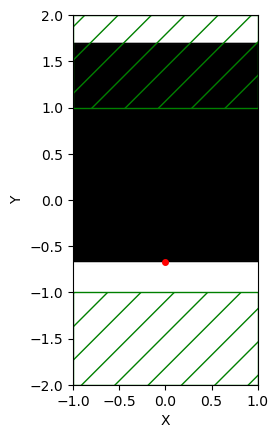

In [114]:
sim_fitting.plot2D(output_plane = mp.Volume(center=mp.Vector3(0, 0, 0), size=mp.Vector3(2, 4, 0)))

In [115]:
offset = 0.01
flux_size = 0.02

# Dipole 위치
source_center = mp.Vector3(0, -0.67,0)

focus_lambda_min = 0.4
focus_lambda_max = 0.7

focus_f_min = 1/focus_lambda_max
focus_f_max = 1/focus_lambda_min

fcen_monitor = 0.5 * (focus_f_min + focus_f_max)
df_monitor = focus_f_max - focus_f_min

box_power_fitting = sim_fitting.add_flux(
    fcen_monitor, df_monitor, nfreq,
    mp.FluxRegion(center=source_center - mp.Vector3(offset, 0, 0),
                  size=mp.Vector3(0, flux_size),
                  # direction=mp.X, 
                  weight=-1),
    mp.FluxRegion(center=source_center + mp.Vector3(offset, 0, 0),
                  size=mp.Vector3(0, flux_size),
                  # direction=mp.X
                  ),
    mp.FluxRegion(center=source_center - mp.Vector3(0, offset, 0),
                  size=mp.Vector3(flux_size, 0),
                  # direction=mp.Y, 
                  weight=-1),
    mp.FluxRegion(center=source_center + mp.Vector3(0, offset, 0),
                  size=mp.Vector3(flux_size, 0),
                  # direction=mp.Y
                  )
)

# sim_fitting_Al.run(until_after_sources = mp.stop_when_fields_decayed(1e-5, mp.Ex, source_center, 0), until = 200)

sim_fitting.run(until = 50)
net_power_fitting = mp.get_fluxes(box_power_fitting)

-----------
Initializing structure...
time for choose_chunkdivision = 0.000626087 s
Working in 2D dimensions.
Computational cell is 31 x 4 x 0 with resolution 100
     block, center = (0,0.515,0)
          size (1e+20,2.37,1)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 1.15477 s
lorentzian susceptibility: frequency=5.05282, gamma=0
lorentzian susceptibility: frequency=2.63601, gamma=0.275275
lorentzian susceptibility: frequency=4.79442, gamma=2.39603e-06
lorentzian susceptibility: frequency=4.87462, gamma=0
lorentzian susceptibility: frequency=4.77321, gamma=0.0786669
lorentzian susceptibility: frequency=11.9833, gamma=8.64311
drude susceptibility: frequency=1, gamma=0.155547
lorentzian susceptibility: frequency=1.47345, gamma=0.579822
lorentzian susceptibility: frequency=0.258842, gamma=5.8094
lorentzian susceptibility: frequency=1.9314, gamma=1.55603
drude susceptibility: frequency=1, gamma=0.0125231
l

### resolution 1000 - air(sourcepower)

In [116]:
from src_resolution import sourcepower

src_wavelengths, src_power = sourcepower(100)

-----------
Initializing structure...
time for choose_chunkdivision = 0.000136852 s
Working in 2D dimensions.
Computational cell is 3 x 3 x 0 with resolution 100
time for set_epsilon = 0.0469971 s
-----------
run 0 finished at t = 20.0 (4000 timesteps)
CSV 파일 저장 완료: sourcepower_res100.csv


In [117]:
import numpy as np
from pathlib import Path

csv_path = Path("/home/min/EIDL/Tool/Meep/LGD/Meep code/OLED structure/Layer by Layer check/New fitting/New fitting data/sio23.49.txt")

# CSV 파일 불러오기
lumerical_data = np.genfromtxt(csv_path, delimiter=",")

lumerical = lumerical_data[:, 1]

In [118]:
import numpy as np
from pathlib import Path

csv_path = Path("/home/min/EIDL/Tool/Meep/LGD/Meep code/OLED structure/Layer by Layer check/New fitting/New fitting data/sio23.49.txt")

# CSV 파일 불러오기
sio2_349 = np.genfromtxt(csv_path, delimiter="," )

sio2_349_data = sio2_349[:, 1]

In [119]:
import numpy as np
from pathlib import Path

csv_path = Path("/home/min/EIDL/Tool/Meep/LGD/Meep code/OLED structure/Layer by Layer check/flux_vs_wavelength.csv")

# CSV 파일 불러오기
res_1000 = np.genfromtxt(csv_path, delimiter=",", skip_header=1)

res_1000_data =np.array( res_1000[:, 1])
res_1000_wave = np.array(res_1000[:,0])

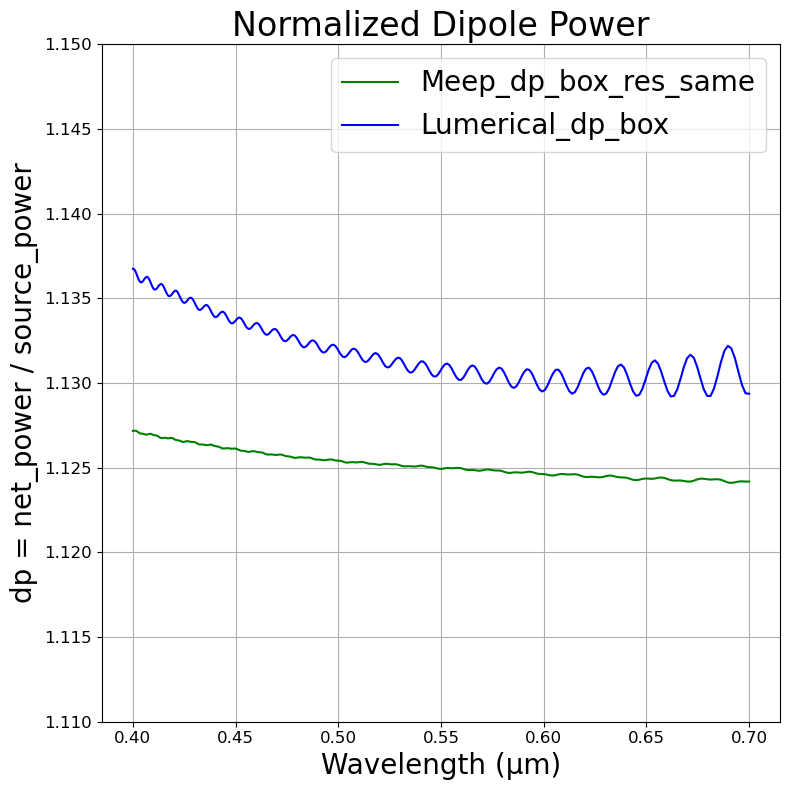

In [124]:
# dp_box / sourcepower 정규화
# dp_fitting = res_1000_data / air_1000 
dp_fitting_100 = np.array(net_power_fitting) / src_power

wavelengths = 1 / np.array(mp.get_flux_freqs(box_power_fitting))

plt.figure(figsize=(8, 8))

# plot 순서
# plt.plot(wavelengths, no_pattern_func, label='Meep_dp_box_res1000', color='red')
plt.plot(wavelengths, dp_fitting_100, label='Meep_dp_box_res_same', color='green')
plt.plot(wavelengths, sio2_349_data, label='Lumerical_dp_box', color='blue')
# plt.plot(wavelengths, decaybox_data, label='decay box rate data', color='purple')
# plt.plot(wavelengths, decay_data, label='decay rate data', color='cyan')

# plt.plot(wavelength_sliced_nofunc, Al_power_sliced_nofunc, label='Lumerical dp', color='green')


# 축 레이블 (굵게 + 크기 조정)
plt.xlabel("Wavelength (μm)", fontsize=20)
plt.ylabel("dp = net_power / source_power", fontsize=20)

# 제목 (굵게 + 크기 조정)
plt.title("Normalized Dipole Power", fontsize=24)

# 눈금 폰트 크기 조정
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# 범례 (폰트 크기 조정 + 굵게)
plt.legend(loc='upper right', fontsize=20, frameon=True,)

# 기타 설정
plt.grid(True)
plt.tight_layout()
plt.ylim([1.11, 1.15])
# plt.xlim([0.4, 0.7])
plt.show()

Average error :  0.6001558662995475 %


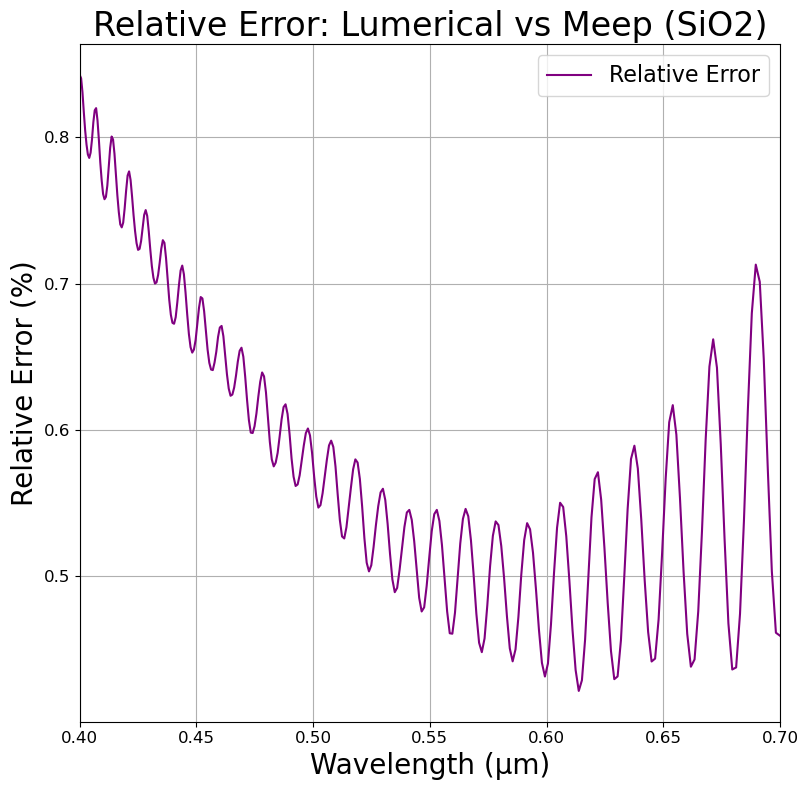

In [125]:
# === Relative Error 계산 === #
relative_error = np.abs((dp_fitting_100 - sio2_349_data) / sio2_349_data)* 100

# === Relative Error 플롯 === #
plt.figure(figsize=(8, 8))
plt.plot(wavelengths, relative_error, label='Relative Error', color='purple')
# plt.plot(wavelengths, relative_error_nofunc, label='Relative Error dp_box', color='cyan')

print("Average error : ", np.mean(relative_error),"%")
# 축 레이블
plt.xlabel("Wavelength (μm)", fontsize=20)
plt.ylabel("Relative Error (%)", fontsize=20)

# 제목
plt.title("Relative Error: Lumerical vs Meep (SiO2)", fontsize=24)

# 눈금, 범례
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.xlim([0.4, 0.7])
plt.show()
